This is the course project for the Practical Machine Learning Course 

In [54]:
if (!require(caret)) {
  install.packages("caret")
}

if (!require(doSNOW)) {
  install.packages("doSNOW")
}

if (!require(randomForest)) {
  install.packages("randomForest")
}

if (!require(gbm)) {
  install.packages("gbm")
}

if (!require(ada)) {
  install.packages("ada")
}

In [55]:
library(caret)
library(doSNOW)
library(tidyverse)
library(lattice)
library(randomForest)
library(gbm)
library(ada)

set.seed(120)

## Data

The data for this project come from this source: http://web.archive.org/web/20161224072740/http:/groupware.les.inf.puc-rio.br/har. We will try to cite them as they have been very generous in allowing their data to be used for this kind of assignment.

In [56]:
url1 = 'https://d396qusza40orc.cloudfront.net/predmachlearn/pml-training.csv'
url2 = 'https://d396qusza40orc.cloudfront.net/predmachlearn/pml-testing.csv'

path1 = "./data/prediction_training.csv"
path2 = "./data/prediction_testing.csv"

if(!dir.exists("./data")) {
  dir.create("./data")
}

if (!file.exists(path1)) {
    download.file(url1, path1)
}

if (!file.exists(path2)) {
    download.file(url2, path2)
}

In [57]:
## Loading in datasets

training = read.csv(path1)
testing = read.csv(path2)

In [58]:
# Isolating the label variable for later use
label = training$classe

## Exploration

We now proceed to do some data analysis. A technique that will be useful for us will be clustering and the help of heatmaps. But if we are to use these we need to ditch all non numeric variables.

### Resolving Variable type

I would like to modify the variables that are problematic.

- First, to systematically replace empty strings with missing values by coercing to numeric
- Second, to make all the variables in the dataframe that are still not coercible to numeric into factor variables. This will allow us to create **dummy variables** out of them later on.

In [59]:
# Coercing to numeric
training = apply(training, 2, as.numeric) %>% as.data.frame %>%

# Batch replacing back for missing values with their selected character values.
mutate(select(training, c(user_name, raw_timestamp_part_1, cvtd_timestamp, new_window )))

Warning message in apply(training, 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(training, 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(training, 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(training, 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(training, 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(training, 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(training, 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(training, 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(training, 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(training, 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(training, 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(training, 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(training, 2, as

Missing values will also present a problem when constructing the heatmap. I think it would be good to see variable by variable, the percentage of missing values for each so that we can see which to keep.

In [60]:
training_na = apply(training, 2, function(x) {is.na(x) %>% sum})

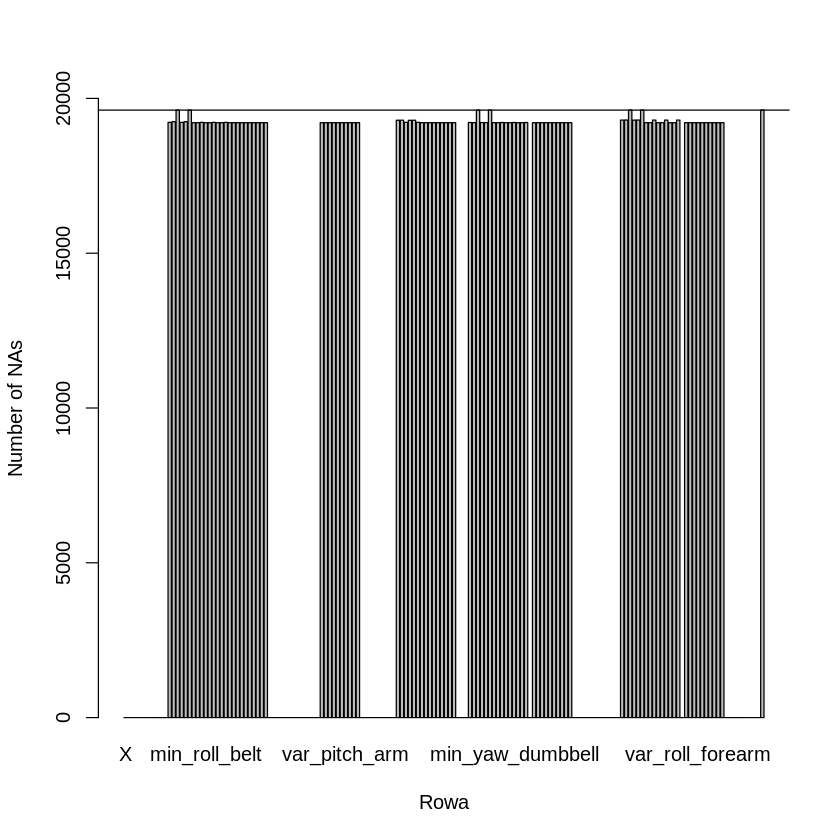

In [61]:
barplot(training_na, xlab = 'Rowa', ylab = 'Number of NAs', ylim = c(0, 20000))
abline(h = nrow(training))

Those long bars show variables that are almost entirely composed of missing values. Given this scale it would perhaps be best to discard them since they will only cause problems for us later on.

In [62]:
training = select(training, where(function(x) is.na(x) %>% sum == 0))

In [63]:
# adding the label variable
training = mutate(training, label = label, .before = 1)

# Model 1: Little Preprocessing

## Functions for our Work

Its nice to wrap up all our code in a function we can reuse;  our training function.

In [64]:
cv_folds = createMultiFolds(y = training$label, k = 10, times = 5)
cv_control = trainControl(
                method = "repeatedcv",
                number = 10,
                repeats = 3,
                index = cv_folds # Necessary: Specifies actual folds for stratified CV
)

In [65]:
model_multithreading = function(data, cores = 1, train_control, method, tune_length) {
  time1 = Sys.time()

  # Creates a doSNOW cluster for doing parallel work.
  cl = makeCluster(cores, type = "SOCK")

  #Notifies caret that training in parallel is available
  registerDoSNOW(cl)

  # Specific Function
  # To be replaced with a function passed in by argument
  modelFit = train(label ~. , method = method, data = data, 
                 trControl = train_control, 
                 tuneLength = tune_length
                )

  stopCluster(cl)
  time2 = Sys.time()

  print(time2 - time1)
  return(modelFit)

}

In [66]:
modelFit1 = model_multithreading(training, cv_control, method = "lda", tune_length = 5, cores = 6)

Warning message in lda.default(x, grouping, ...):
“variables are collinear”


Time difference of 44.78447 secs


In [67]:
modelFit1

Linear Discriminant Analysis 

19622 samples
   59 predictor
    5 classes: 'A', 'B', 'C', 'D', 'E' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 17659, 17660, 17661, 17661, 17659, 17658, ... 
Resampling results:

  Accuracy   Kappa    
  0.9999388  0.9999226


In [53]:
predict(modelFit1, newdata = testing)

[1] A A A A A A A A A A A A A A A A A A A A
Levels: A B C D E

# Model 2

## Preprocessing

Covariates are variables that describe the data as much as possible while allowing for compression and fitting of models.  
We want to balance summarization and information loss.

### Dummy Variables

caret includes several functions to pre-process the predictor data. It assumes that all of the data are numeric (i.e. factors have been converted to dummy variables via <code> model.matrix </code>, <code> dummyVars </code> or other means).

In [18]:
# Separating the date and time sections into different variables
training = tidyr::separate(training, cvtd_timestamp, sep= " ", into = c("cvtd_datetamp", "cvtd_timestamp")) %>%
                select(-cvtd_timestamp)

# Converting into date time object
training = mutate(training, cvtd_datestamp =  lubridate::dmy(training$cvtd_datetamp))

In [19]:
training =
select(training, -c(user_name, new_window)) %>% 
  # Adding dummy variables 
  cbind(model.matrix(label ~., data = select(training, user_name, new_window)))

### Zero Variance Predictors

These are predictors might have only a handful of unique values that occur with very low frequencies. These may cause training methods to be unstable.


<code> nearZeroVar() </code> returns index locations of the columns that fall below a certain frequency threshold usually 95/5.

In [20]:
train_numeric = select(training, where(is.numeric))
nzv = nearZeroVar(train_numeric)


In [21]:
#Removing non zero variables
training = select(training, -names(train_numeric)[nzv])

### The preProcess Function

The preProcess class can be used for many operations on predictors, including centering and scaling. The function preProcess estimates the required parameters for each operation and <code> predict.preProcess </code> is used to apply them to specific data sets.


#### Center and Scaling

The function preProcess doesn’t actually pre-process the data. <code> predict.preProcess </code>is used to pre-process this and other data sets.  

Passing in the dataset, note that non-numeric predictors are allowed but will be ignored.

#### Imputation

<code> preProcess </code> can be used to impute data sets (if necessary) based only on information in the training set. Methods include:
- K-nearest neighbors.
- Bagging. Better performance but more computationally intensive.

#### PCA

Apply this transformation involves including "pca" in the method argument. Doing this will also force scaling of the predictors. 
   
Note that when PCA is requested, predict.preProcess changes the column names to PC1, PC2, ..., PCn.

Also, 
we can add this filter to check near zero-variance predictors prior to running the pre-processing calculations. Some models like that.

In [22]:
training = 
preProcess(training, method = c("pca", "nzv")) %>%
  predict(training)

## Training


### Tuning

This basically involves the following process

![Model Tuning](http://topepo.github.io/caret/premade/TrainAlgo.png)

Methods available are 
- k-fold cross-validation (once or repeated)
- leave-one-out cross-validation 
- bootstrap (simple estimation or the 632 rule) 

The function <code> trainControl </code> generates parameters that further control how models are created, with possible values:

In [23]:
modelFit2 = model_multithreading(training, cv_control, method = "lda", tune_length = 5, cores = 6)

Warning message in lda.default(x, grouping, ...):
“variables are collinear”


Time difference of 28.5357 secs


In [24]:
modelFit2

Linear Discriminant Analysis 

19622 samples
   29 predictor
    5 classes: 'A', 'B', 'C', 'D', 'E' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 17659, 17660, 17661, 17661, 17659, 17658, ... 
Resampling results:

  Accuracy   Kappa    
  0.9850375  0.9810801


In [71]:
saveRDS(modelFit2, file = "./data/model2_lda.rds")

So our model appears to be operating at quite a high accuracy, over 0.99. This is a little hard to believe but given this is in sample it will have to be tested out of sample to verify this.

## Testing Perfomance


Our model predicts all the cases are in class A. It is highly accurate in sample but because i did not create a separate testing set from the training data I have no idea what its out of sample accuracy is.


Testing on the Quiz reveals that this model only has 0.35 percent accuracy out of sample. This suggests that it is grossly overfitted.

# Model 3: With More Preprocessing

In [72]:
# Rereading data
training = read.csv(path1)
testing = read.csv(path2)

## Joining sets

The need to perform the same cleaning to both the training and testing set would require us to first combine them and then preprocess then. After that the data will be resplit and the model trained and tested

In [73]:
# Looking at whether column names match up
names(training) == names(testing)

# Removing Columns that dont match up
training = training[,-160]
testing = testing[,-160]

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [13]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [25]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [37]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [49]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [61]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [73]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [85]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [97]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[109]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[121]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[133]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[145]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[157]  TRUE  TRUE  TRUE FALSE

We learnt that the last columns do not match up. For the training set it is the label/classe variable and for the testing set it is a problem_id column.

It is best to remove them then call <code> rbind() </code> on them

In [74]:
joint_set = rbind(testing, training)

## Preprocessing Function

In the same way we preprocessed the training set we also have to do the same to the testing set so that we can make predictions on it.


In [75]:
preprocessing_datasets = function (data_frame) {
  set.seed(120)
    # Coercing to numeric
  data_frame = apply(data_frame, 2, as.numeric) %>% as.data.frame %>%

  # Batch replacing back for missing values with their selected character values.
  mutate(select(data_frame, c(user_name, raw_timestamp_part_1, cvtd_timestamp, new_window )))
  # Removing missing value columns
  data_frame = select(data_frame, where(function(x) is.na(x) %>% sum == 0))

  # Separating the date and time sections into different variables
  data_frame = tidyr::separate(data_frame, cvtd_timestamp, sep= " ", into = c("cvtd_datetamp", "cvtd_timestamp")) %>%
                  select(-cvtd_timestamp)

  # Converting into date time object
  data_frame = mutate(data_frame, cvtd_datestamp =  lubridate::dmy(data_frame$cvtd_datetamp))

  # Error handling
  
  tryCatch(			

  # Specifying expression
  expr = {					
      # Adding dummy variables
      data_frame =
      select(data_frame, -c(user_name, new_window)) %>% 
      
      cbind(model.matrix(~., data = select(data_frame, user_name, new_window)))
  },
  # Specifying error message
  error = function(e){		
    print("There was an error message.")
  },

  finally = {			
      train_numeric = select(data_frame, where(is.numeric))
      nzv = nearZeroVar(train_numeric)

      #Removing non zero variables
      data_frame = select(data_frame, -names(train_numeric)[nzv])

      train_numeric = select(data_frame, where(is.numeric))
      nzv = nearZeroVar(train_numeric)

      #Removing non zero variables and doing pca
      data_frame = preProcess(data_frame, method = c("pca", "nzv")) %>%
          predict(data_frame)

      return(data_frame)
  }
  )

}


In [76]:
clean_set = preprocessing_datasets(joint_set)

# Removing duplicate column
clean_set = select(clean_set, -c(cvtd_datetamp, cvtd_datestamp))

## Resplitting

We select the first twenty records as these correspond to the original testing set which needs to remain as is.

In [77]:
testing = clean_set[1:20,]
training = clean_set[-c(1:20),]

# Adding back label column
training = mutate(training, label = label)

## Training

In [78]:
modelFit3 = model_multithreading(training, cv_control, method = "lda", tune_length = 5, cores = 6)

Time difference of 26.9893 secs


## Testing

In [79]:
predict(modelFit3, newdata = testing)

[1] A A A A A A A A A A A A A A A A A A A A
Levels: A B C D E

# Conclusions



It has to be admitted that our modela have not done a good job. They have extremely high accuracy during valuation but performed terribly on the test set (evaluated externally).

This appears to me to be overfitting and I have no clue as to how to fix the problem at this stage.